Trying another tutorial using this [approach](https://www.kaggle.com/zakarii/dna-sequence-classification-cnn-gru)

In [4]:
import pandas as pd
import numpy as np
import os

import joblib

from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras

In [78]:
!ls ../data

sequences.aln.fas


In [57]:
inputfile = '../data/sequences.aln.fas'

lines = []
header = []
with open (inputfile, 'r') as fasta_file:
    
    for line in fasta_file:
        if line.startswith(">"):
            lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            #lines.append(line.replace('\w', '').replace(">", "").replace("\n","\t"))
        next
        if not line.startswith(">"):
            header.append(line.replace("\n",''))
            
data = {lines[i]:header[i] for i in range(len(header))}

data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 
data["sequence"] = data["sequence"].str.upper()

data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0])

data = data.drop("Seq_ID", axis=1)

data.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,gamma
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,gamma
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,delta
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,delta
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,delta


In [60]:
data.Variant_Id.unique()

array(['gamma', 'delta', 'beta', 'omicron', 'alpha'], dtype=object)

In [61]:
variant = {"gamma" : 0, "delta" : 1, "beta":2, "alpha":3, "omicron":4}
data["Variant_Id"] = data["Variant_Id"].map(variant)
data.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,1
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,1
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,1


In [62]:
#Check characters in the seqeunce column

ntds = []
for i in data['sequence']:
    for seq in i:
        ntd = seq.strip()
        ntds.append(ntd)
        
char = list(set(ntds))
char

['A', '-', 'C', 'T', 'K', 'B', 'R', 'Y', 'M', 'S', 'N', 'G', 'W']

In [64]:
sequence_data = list(data.loc[:, 'sequence'])

In [65]:
encoded_list = []

def encode_seq(s):
    Encode = {'A':[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'T':[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],
                'C':[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'G':[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,0,0], 
                '-':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'N':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],
                'K':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'R':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'M' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],
                'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0], 'Y' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0], 
                'S':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0], 'D':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0],'B':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0]}
    return [Encode[x] for x in s]

for i in sequence_data:
    x = encode_seq(i)
    encoded_list.append(x)

X_mine = np.array(encoded_list)
X_mine.shape

(26037, 3874, 13)

In [71]:
X_mine.shape[1:]

(3874, 13)

In [72]:
data["Variant_Id"].unique()

array([0, 1, 2, 4, 3])

In [73]:
y_mine = data['Variant_Id']
y_mine.shape

(26037,)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_mine, y_mine, random_state = 42, stratify = y_mine)
from keras import utils as np_utils

y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [75]:
params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32], 
    'dropout': [0.1, 0.2, 0.5]
}

gru_model = Sequential()

#Layer 1 - feature extraction
#Performs dimension reduction

gru_model.add(Conv1D(filters = 27, kernel_size = (4), activation = 'relu', input_shape = X_mine.shape[1:])) #ensure you change the shape
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Dropout(0.2))
gru_model.add(Conv1D(filters = 14, kernel_size = (2), activation = 'relu', padding = 'same'))


gru_model.add(Bidirectional(GRU(128, activation = 'relu')))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
gru_model.add(Dense(5, activation = 'softmax'))

gru_model.add(Flatten())

gru_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2022-04-11 10:37:47.623679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3871, 27)          1431      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1290, 27)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1290, 27)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1290, 14)          770       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              110592    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [77]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )
history = gru_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=5)

Epoch 1/5
  5/153 [..............................] - ETA: 23:28 - loss: 0.7536 - accuracy: 0.2031

KeyboardInterrupt: 

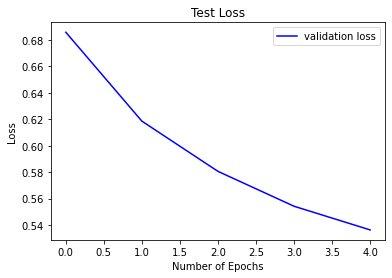

In [ ]:
# Plot the loss and accuracy curves for training and validation 

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

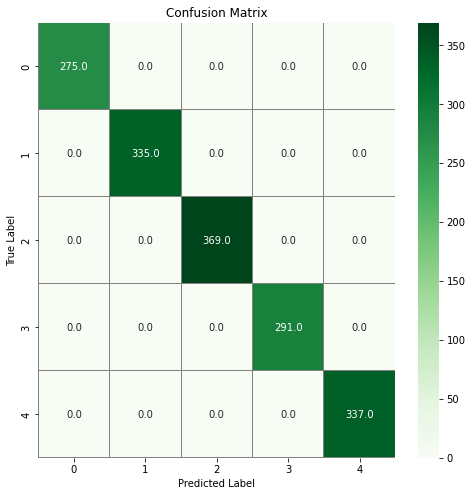

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = gru_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_test,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()